# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Add any additional import statements you need here
from lexical_diversity import lex_div as ld
import numpy as np
from nltk import FreqDist
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"/s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, top_n_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    # Place your Module 2 solution here
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = ld.ttr(tokens) # Simple TTR = len(Counter(text))/len(text)
    num_characters = sum([len(i) for i in tokens])
    
    if verbose:        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"The top {top_n_tokens} most common tokens")
        print(Counter(tokens).most_common(top_n_tokens))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return([t for t in tokens if t.lower() not in sw])
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return text.lower().strip().split() 

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer
# change to your location if it is not in the same directory as your notebook
data_location = "C:/Users/zfreitas/Dropbox/Classes/USD/ADS-509-01-SP23 - Applied Text Mining/2. Module Two/Assignment 1/M1 Results/" 
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

twitter_data = twitter_data.fillna('')

In [7]:
# Read in the lyrics data

# Dictionary Approach 2 - Using defaultdict
# d[artist][title] = “the song lyrics as a string”
lyrics = defaultdict(lambda: defaultdict(str))

# Get the directory location and all the subfolders in directory.
directory = data_location + lyrics_folder
artist_folders = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

# Get all the files in each of the subfolders
for artist in artist_folders:
    artist_path = os.path.join(directory, artist)
    for file in os.listdir(artist_path):
        file_path = os.path.join(artist_path, file)
        if os.path.isfile(file_path):
            with open(file_path) as f:
                title = f.readline().strip()
                lyrics[artist][title] = f.read().strip()


In [8]:
# Check my work
lyrics["robyn"].get('"88 Days"')

"I light a candle in the morning \nTo signify that your still on my mind\nDarkness arrived without a warning \nIt brought me down\nBut I know the world just keeps on turning\n\nI wish that I could turn you on \nLike a switch in my kitchen \nRight before dawn\n88 days seems so long\nI believe in you and me\nBut it's so hard to trust\nSomething you just can't see, still I've got\n\n[CHORUS]\n88 days 'til the sun\nAnd while you're gone\nI've got so much work inside my heart to be done, I've got\n88 days 'til the sun\nI`ve got to get my spirit ready\nFor when the springtime comes\n88 days 'til the sun\n\nZip up my thickest jacket \nI miss the green and the light you gave to me\nPrepare to get my feet wet\nHalogen's on bright when 2 pm is like 2 in the night, it ain't right\nSo what's the message in this song\nThat the pain doesn't mean that you can't carry on\nStill 88 days seem so long\nA meditation, a revelation\nBut it's so hard to trust\nSomething you just can't see, still I've got\n\n

In [9]:
# Create lyrics Pandas Dataframe for Cleaning
artists = ['cher', 'robyn']
lyrics_df = pd.DataFrame()

for artist in artists:
    lyrics_df_temp = pd.DataFrame(lyrics[artist].items(), columns=['title', 'lyrics'])
    lyrics_df_temp['artist'] = artist
    lyrics_df = pd.concat([lyrics_df, lyrics_df_temp])

lyrics_data = lyrics_df.fillna('')

lyrics_data

,title,lyrics,artist
0,"""88 Degrees""","Stuck in L.A., ain't got no friends \nAnd so H...",cher
1,"""A Different Kind Of Love Song""",What if the world was crazy and I was sane\nWo...,cher
2,"""After All""","Well, here we are again\nI guess it must be fa...",cher
3,"""Again""",Again evening finds me at your door \nHere to ...,cher
4,"""Alfie""","What's it all about, Alfie?\nIs it just for th...",cher
...,...,...,...
88,"""We Dance To The Beat""",We dance to the beat\nWe dance to the beat\nWe...,robyn
89,"""Where Did Our Love Go""",Thoughts about you and me \nThinkin' about wha...,robyn
90,"""Who's That Girl""",Good girls are pretty like all the time\nI'm j...,robyn
91,"""With Every Heartbeat""",Maybe we could make it all right\nWe could mak...,robyn


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [10]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [11]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [12]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
3741178,cher,♥Be your kind of beautiful♥,"[♥be, kind, beautiful♥]"
442674,cher,Say it like it is. Animal lover! ❤️ Boston ter...,"[say, like, animal, lover, ❤️, boston, terrier..."
1418253,cher,Ask... Believe.... Receive ✨🌎,"[ask, believe, receive, ✨🌎]"
2915383,cher,"Authors of ""The Dog Who Saved Pleasantville, a...","[authors, dog, saved, pleasantville, tail, lif..."
2795279,cher,"Stand still, let me paint you. Gemini ♊","[stand, still, let, paint, gemini, ♊]"
206549,cher,🏳️‍🌈,[🏳️‍🌈]
821531,cher,🌷,[🌷]
1324530,cher,Rumo ao desconhecido. 💻📷🌍🛫,"[rumo, ao, desconhecido, 💻📷🌍🛫]"
1069609,cher,👹artist |CGA,"[👹artist, cga]"
1719229,cher,journalist & documentarian 🤟,"[journalist, documentarian, 🤟]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I think there are several areas of improvement that could be made, especially on the twitter data. One is spelling correction. Removeal of numbers is another. This would be harder to do, cause some numbers have context assigned to them. Numbers like 9/11 or 911. It might also be nice to add the parts of speach that the tokens are in improve context.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [13]:
# calls to descriptive_stats here

# Helper Function
def flatten_and_descriptive_stats(list_of_lists):
    wordlist = [i for s in list_of_lists for i in s]
    return descriptive_stats(wordlist)


In [14]:
print("\nTweets for Cher:\n")
flatten_and_descriptive_stats(lyrics_data.loc[lyrics_data['artist']=='cher']["tokens"])


Tweets for Cher:

There are 34901 tokens in the data.
There are 3682 unique tokens in the data.
There are 167640 characters in the data.
The lexical diversity is 0.105 in the data.
The top 5 most common tokens
[('love', 917), ('im', 510), ('know', 473), ('dont', 428), ('youre', 331)]


[34901, 3682, 0.10549840978768517, 167640]

In [15]:
print("\nTweets for Robyn:\n")
flatten_and_descriptive_stats(lyrics_data.loc[lyrics_data['artist']=='robyn']["tokens"])


Tweets for Robyn:

There are 13019 tokens in the data.
There are 2139 unique tokens in the data.
There are 62875 characters in the data.
The lexical diversity is 0.164 in the data.
The top 5 most common tokens
[('im', 255), ('dont', 252), ('love', 238), ('know', 237), ('got', 230)]


[13019, 2139, 0.1642983332053153, 62875]

Q: what observations do you make about these data? 

A: Both Robyn and Cher lyrics have the same top 5 words. It is interesting to note that Robyn's lyrics have more lexical diversity than Cher's lyrics. It's interesting that this trend for lexical diversity follows for the two artist's tweets too.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [16]:
# your code here

def token_normal(text): 

    # Lowercase and split on whitespace 
    text = text.lower().strip().split() 

    # Drop non—alpha and stopwords 
    text =  [w for w in text if w not in sw and w.isalpha()]

    return(text) 
    

def get_patterns(text, num_words):
    """ 
    This function takes text as an input and returns a dictionary Of statistics, 
    after cleaning the text. 
    """
    if (len(text) == 0):
        raise ValueError("Can't work with empty text object.") 


    # We'll make things a big clearer by the 
    # statistics here. These are placeholder values. 
    total_tokens = 1
    unique_tokens = 0
    avg_token_len = 0.0
    lex_diversity = 0.0
    top_words =[]
    
    text = token_normal(text) 

    if len(text) == 0:
        raise ValueError( " All of text is stopwords! " ) 


    # Calculate your statistics here 
    total_tokens = len(text) 
    unique_tokens = len(set(text)) 
    avg_token_len = np.mean([len(w) for w in text]) 
    lex_diversity = unique_tokens/total_tokens

    top_words = FreqDist(text).most_common(num_words) 
    
    # Now we'll fill out the dictionary. 
    results = { 'tokens' : total_tokens, 
            'unique_tokens' : unique_tokens,
            'avg_token_length' : avg_token_len,
            'lexical_diversity': lex_diversity,
            'top_words': top_words} 

    return(results) 

def get_word_frac(word, fd_corpus, length):  

    if word in fd_corpus:
        return(fd_corpus[word]/length) 
    else: 
        return(0)

def get_ratio(word, fd_corpus_1, fd_corpus_2, len_1, len_2):

    frac_1 = get_word_frac(word, fd_corpus_1, len_1) 
    frac_2 = get_word_frac(word, fd_corpus_2, len_2) 

    if frac_2 > 0:
        return(frac_1/frac_2) 
    else:
        return(float('NaN')) 

def compare_texts(corpus_1, corpus_2, num_words = 10, ratio_cutoff=5): 
    """
    This function returns a nested dictionary with information comparing two groups Of 
    text. See README for full description of what this function does. 
    """
    results = dict() 

    # Get the first two parts done with a function 
    results["one"] = get_patterns(corpus_1, num_words)
    results["two"] = get_patterns(corpus_2, num_words)

    # Now we start the ratio part. Cleaning first, then build 
    # frequency distributions 
    corpus_1 = token_normal(corpus_1) 
    corpus_2 =  token_normal(corpus_2)
    
    fd_1 = FreqDist(corpus_1) 
    fd_2 = FreqDist(corpus_2)

    # It's handy to have a set of the words in each corpus. 
    
    fd_1_words = set(fd_1.keys()) 
    fd_2_words = set(fd_2.keys()) 
    
    # This will hold our ratios. Starting with 1 over 2 
    holder = dict() 
    
    # Also, we need to tell Python that the "one_vs two" spot holds 
    # a dictionary. (And "two vs one") 
    results["one_vs_two"] = dict() 
    results["two_vs_one"] = dict() 
    
    # Now we add them. We check along the to make Sure 
    for word, count in fd_1.items():
        if count > ratio_cutoff:
            # This next line makes use of the fact that 
            # Python stops evaluating "and" expressions if it hits a False 
            if word in fd_2_words and fd_2[word] > ratio_cutoff:
                holder[word] = get_ratio(word, fd_1, fd_2,
                results["one"]["tokens"],
                results["two"]["tokens"])
    
    num_added = 0

    for word, frac in sorted(holder.items() , key=lambda item: -1*item[1]):
        results["one_vs_two"][word] = frac
        num_added += 1
        if num_added == num_words:
            break 

    # Now we do the same for 2 vs 1!
    holder = dict() 
    
    # Now we add them. We check along the to make Sure 
    for word, count in fd_2.items():
        if count > ratio_cutoff:
            # This next line makes use of the fact that 
            # Python stops evaluating "and" expressions if it hits a False 
            if word in fd_1_words and fd_1[word] > ratio_cutoff:
                holder[word] = get_ratio(word, fd_2, fd_1,
                results["two"]["tokens"],
                results["one"]["tokens"])
    
    num_added = 0    
    
    for word, frac in sorted(holder.items() , key=lambda item: -1*item[1]):
        results["two_vs_one"][word] = frac
        num_added += 1
        if num_added == num_words:
            break 
    
    return(results) 

# Twitter Data
First let's look that the Twitter data.

In [17]:
text1 = twitter_data.loc[twitter_data['artist']=='cher']['description']
text2 = twitter_data.loc[twitter_data['artist']=='robyn']['description']
compare_texts_results = compare_texts( " ".join(text1) , " ".join(text2), num_words=10) 

In [18]:
compare_texts_results["one"]

{'tokens': 9941853,
 'unique_tokens': 421383,
 'avg_token_length': 5.546743147379065,
 'lexical_diversity': 0.04238475463276313,
 'top_words': [('love', 198887),
  ('life', 86174),
  ('de', 72776),
  ('music', 60071),
  ('follow', 59539),
  ('like', 56907),
  ('one', 41809),
  ('live', 41108),
  ('la', 39443),
  ('im', 37431)]}

In [19]:
compare_texts_results["two"]

{'tokens': 955903,
 'unique_tokens': 109164,
 'avg_token_length': 5.612509846710388,
 'lexical_diversity': 0.11419987174430879,
 'top_words': [('love', 10465),
  ('music', 10266),
  ('och', 7895),
  ('de', 6353),
  ('follow', 5342),
  ('life', 4984),
  ('en', 4802),
  ('like', 4738),
  ('på', 4709),
  ('new', 3521)]}

In [20]:
compare_texts_results["one_vs_two"]

{'grandmother': 35.26759251016888,
 'grandma': 20.96056479612,
 'democrat': 11.548227295110019,
 'trump': 11.098385553908885,
 'nascar': 10.44823260479376,
 'retired': 10.02090202791058,
 'cowboys': 9.31275421478988,
 'biden': 8.967532155893542,
 'patriot': 8.589344595351927,
 'grandson': 8.529823550714626}

In [21]:
compare_texts_results["two_vs_one"]

{'sveriges': 202.46273774640312,
 'människor': 194.14235126367427,
 'brinner': 193.15182906334937,
 'följ': 187.20869586140017,
 'spelar': 182.75134595993825,
 'arbetar': 182.4812035416678,
 'gärna': 175.76816444764793,
 'försöker': 164.9219463540906,
 'kommunikatör': 161.950379753116,
 'stora': 149.07359114889275}

# Lyrics Data
Now let's look at the lyrics data.

In [22]:
text1 = lyrics_data.loc[lyrics_data['artist']=='cher']['lyrics']
text2 = lyrics_data.loc[lyrics_data['artist']=='robyn']['lyrics']
compare_texts_lyrics_results = compare_texts( " ".join(text1) , " ".join(text2), num_words=10) 

In [23]:
compare_texts_lyrics_results["one"]

{'tokens': 28271,
 'unique_tokens': 3225,
 'avg_token_length': 4.866152594531498,
 'lexical_diversity': 0.11407449329701815,
 'top_words': [('love', 851),
  ('know', 441),
  ('time', 299),
  ('see', 284),
  ('one', 267),
  ('like', 256),
  ('come', 248),
  ('take', 246),
  ('go', 246),
  ('never', 242)]}

In [24]:
compare_texts_lyrics_results["two"]

{'tokens': 10115,
 'unique_tokens': 1820,
 'avg_token_length': 4.914780029658923,
 'lexical_diversity': 0.17993079584775087,
 'top_words': [('know', 229),
  ('got', 221),
  ('love', 213),
  ('like', 196),
  ('baby', 169),
  ('never', 136),
  ('get', 127),
  ('gonna', 105),
  ('right', 104),
  ('want', 102)]}

In [25]:
compare_texts_lyrics_results["one_vs_two"]

{'find': 7.81168570855883,
 'man': 7.672546268457273,
 'believe': 7.453898576869112,
 'enough': 5.903487672880337,
 'us': 3.6375025055121273,
 'well': 3.44776690537364,
 'till': 3.2797153738224094,
 'hope': 3.100821807977551,
 'many': 3.041190619362598,
 'door': 2.981559430747645}

In [26]:
compare_texts_lyrics_results["two_vs_one"]

{'beat': 13.229467787114848,
 'work': 11.925154061624651,
 'dance': 9.528265851795263,
 'hang': 8.384873949579832,
 'shake': 7.919047619047619,
 'space': 6.638025210084034,
 'moment': 6.388475390156062,
 'alright': 5.869411764705883,
 'control': 5.869411764705883,
 'hurts': 5.124089635854341}

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: I noticed that Cher's tweets are more American centric in content, whereas Robyn had more Swedish unique words. I also noticed that Robyn's lyics may be more dance themed.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [27]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

# Word Cloud Plotting

In [28]:
# plot helper function
def plot_wc(wordcloud_df):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)###
    wordcloud(wordcloud_df['freq'], max_words=1000)
    plt.subplot(1,2,2)###
    wordcloud(wordcloud_df['freq'], max_words=1000, stopwords=sw)
    plt.tight_layout()###

# Cher's Lyrics
With stopwords and without stopwords.

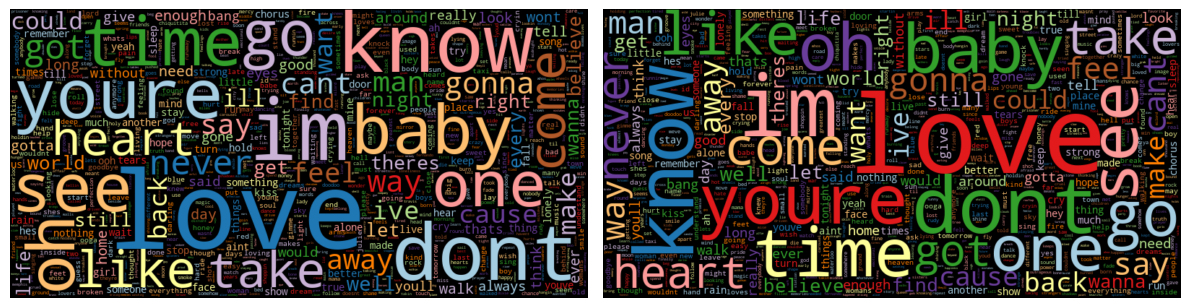

In [29]:
wordcloud_df = count_words(lyrics_data.loc[lyrics_data['artist']=='cher'])
plot_wc(wordcloud_df)

# Robyn's Lyrics
With stopwords and without stopwords.

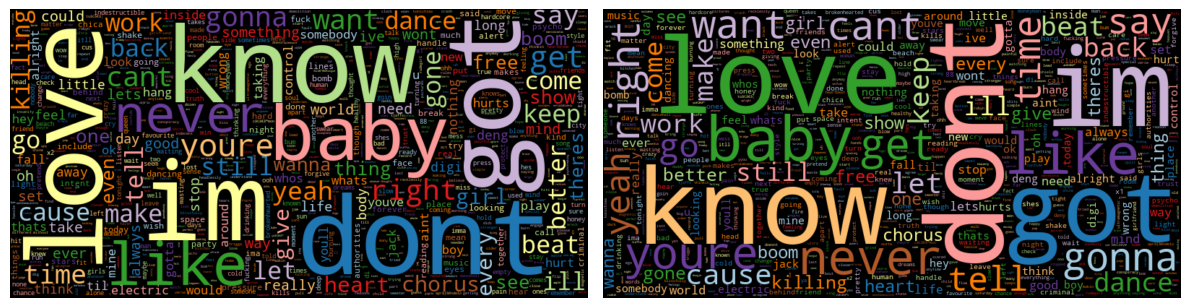

In [30]:
wordcloud_df = count_words(lyrics_data.loc[lyrics_data['artist']=='robyn'])
plot_wc(wordcloud_df)

# Cher's Tweets
With stopwords and without stopwords.

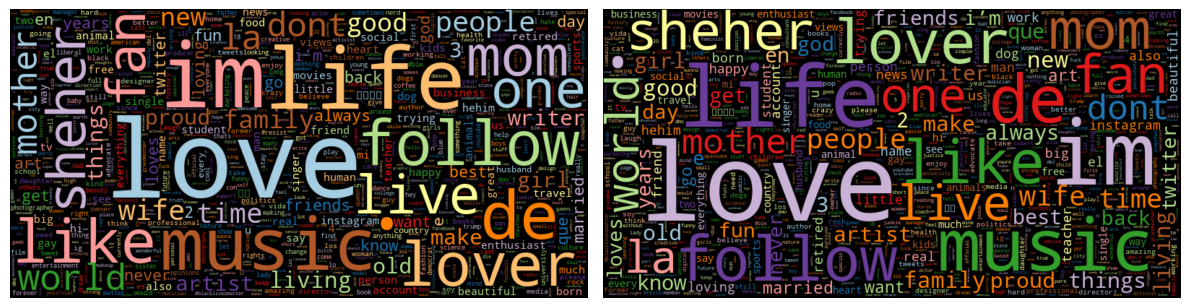

In [31]:
wordcloud_df = count_words(twitter_data.loc[twitter_data['artist']=='cher'])
plot_wc(wordcloud_df)

# Robyn's Tweets
With stopwords and without stopwords.

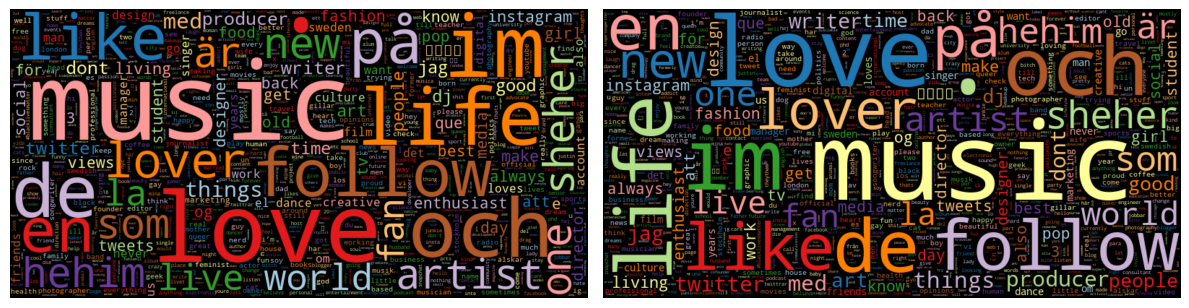

In [32]:
wordcloud_df = count_words(twitter_data.loc[twitter_data['artist']=='robyn'])
plot_wc(wordcloud_df)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Both Cher and Robyn's fans love love and music. Cher's fans tend to focus on her being a mother, whereas Robyn's fans tend to focus more on pronouns. Lyricaly the seem the same based upon the common words used in the wordcloud.